In [87]:
import hashlib
import random
import pandahouse
import seaborn as sns
from scipy import stats

In [1]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': '',
    'user': 'student',
    'database': 'simulator'
}

q = """
SELECT distinct user_id
FROM simulator_20220820.feed_actions
WHERE toDate(time) >= '2022-07-06' and toDate(time) <= '2022-07-12'
"""

In [89]:
def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [90]:
# Вытащили пользователей
users_df = pandahouse.read_clickhouse(q, connection=connection)

# Сделали группы
users_df['hash_group'] = users_df.user_id.swifter.apply(ab_split)

# Смотрим на число пользователей в каждой группе
users_df.groupby('hash_group').user_id.nunique().reset_index()

Pandas Apply:   0%|          | 0/42585 [00:00<?, ?it/s]

,hash_group,user_id
0,0,8725
1,1,8354
2,2,8516
3,3,8433
4,4,8557


In [91]:
# Проверка корректности системы сплитования
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220820.feed_actions
WHERE toDate(time) between '2022-07-06' and '2022-07-12'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


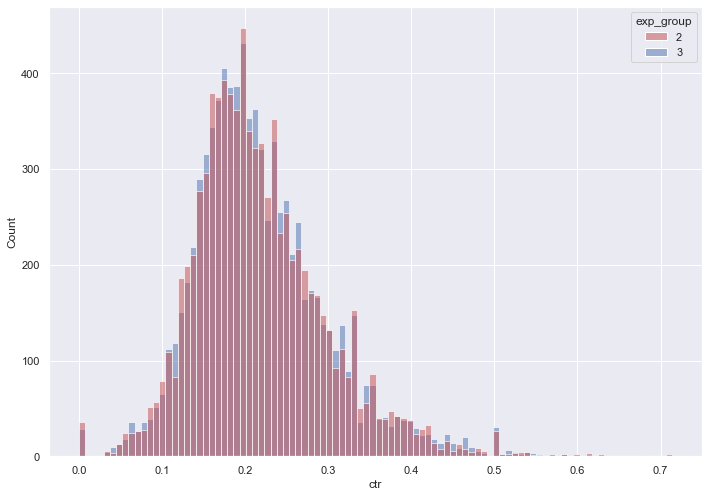

In [92]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df,
                      x='ctr',
                      hue='exp_group',
                      palette = ['r', 'b'],
                      alpha=0.5,
                      kde=False)

In [93]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)


Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

In [94]:
#Считаем CTR в группах 2 и 3
gr2_ctr = (df[df.exp_group == 2].ctr).values.tolist()
gr3_ctr = (df[df.exp_group == 3].ctr).values.tolist()

In [95]:
#Проводим 10 000 АА-тестов с подвыборкой = 500 элементов в каждой группе, получившийся p-value от каждого эксперимента складываем в лист
p_list=[]
for i in range(10000):
    a = random.sample(gr2_ctr, k=500)
    b = random.sample(gr3_ctr, k=500)
    p = stats.ttest_ind(a, b, equal_var=False)[1]
    p_list.append(p)


<AxesSubplot:ylabel='Count'>

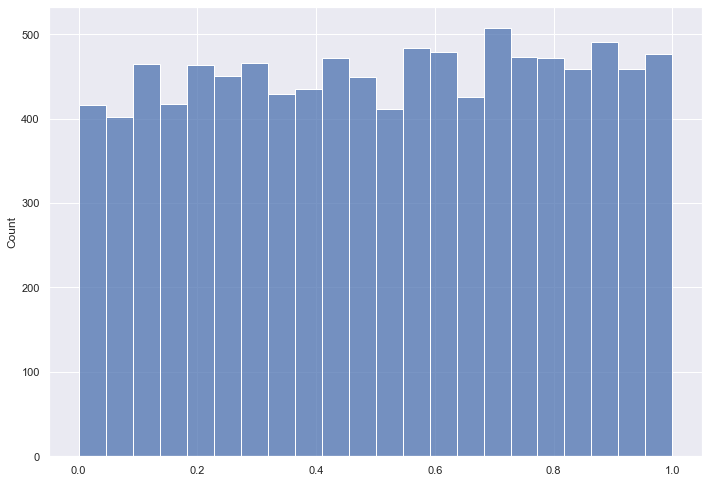

In [96]:
#Строим график с распределением получившихся p-value. Видно, что большинство p-value>0,05
sns.histplot(data = p_list)

In [97]:
#Считаем долю экспериментов с p_value <= 0.05
count = filter(lambda p_value: p_value <= 0.05, p_list)
len(list(count))/10000

0.0441

По результатам 10 000 тестов получилось, что p-value <=0,05 всего в 4,41% случаев, значит, в 4,41% случаев мы посчитали бы группы статистически различными. Таким образом считаем, что система сплитования работает корректно и статистически значимые различия между группами могут встречаться только из-за ложного срабатывания.